# Draft analysis 

---

Group name: Group C, Burcin Aksel & Nico Henzel

---


## Setup

In [1]:
import pandas as pd
import numpy as np
import missingno as mno # needed to visualize missing values. install missingno into conda if import does not work!
import altair as alt
import matplotlib.pyplot as plt
import xlrd # needed to read excel files. install xlrd into conda if import does not work!
import shutil # needed to copy files
import warnings
from vega_datasets import data # needed for US map, installed vega_dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


warnings.simplefilter(action='ignore', category=FutureWarning)
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

## Introduction

The aim of this project is to investigate whether there is a correlation between the household income and the death rate in the United States of America. In order to explore this relation, we gathered data on both topics and will analyse how and to what extense the death rate is impacted by the household income.

### Research Question

We want to answer the following question:

**Does the household income have an impact on the deathrates in the U.S. and if yes, how big is it?**

The predictor variable will be the median household income and the response variable will be the age-adjusted death rate. Further insight can be gained by using categories like death cause, state or year. Other useful information will be provided by the amount of total deaths.
The data dictionary below is showing more details about the required variables.

In [2]:
data = {
        'Name': [
                'state',
                'year',
                'median_household_income',
                'cause name',
                '113 cause name',
                'deaths',
                'Age-adjusted Death Rate'
                ], 
        'Description': [
                'the state where data was collected',
                'considered years','median household income',
                'the generic name for the death cause',
                'NDI ICD-10 113 categories for causes of death',
                'count of the total deaths',
                'standardized death percentage for a state'
                ],
        'Role': [
                'predictor',
                'predictor',
                'predictor',
                'predictor',
                'Not used',
                'ID',
                'response'
                ],
        'Type': [
                'nominal',
                'numeric discrete',
                'numeric continuous',
                'nominal',
                'nominal',
                'numeric discrete',
                'numeric continuous'
                ],
        'Format': [
                'category',
                'date',
                'float',
                'category',
                'category',
                'int',
                'float'
                ],
        }

df = pd.DataFrame(data)

df

Name                                    Description  \
0                    state             the state where data was collected   
1                     year                               considered years   
2  median_household_income                        median household income   
3               cause name           the generic name for the death cause   
4           113 cause name  NDI ICD-10 113 categories for causes of death   
5                   deaths                      count of the total deaths   
6  Age-adjusted Death Rate      standardized death percentage for a state   

        Role                Type    Format  
0  predictor             nominal  category  
1  predictor    numeric discrete      date  
2  predictor  numeric continuous     float  
3  predictor             nominal  category  
4   Not used             nominal  category  
5         ID    numeric discrete       int  
6   response  numeric continuous     float

Our research question is backed by the following studies:
* KINGE, Jonas Minet, et al. Association of household income with life expectancy and cause-specific mortality in Norway, 2005-2015. Jama, 2019, 321. Jg., Nr. 19, S. 1916-1925. (https://jamanetwork.com/journals/jama/article-abstract/2733322)
* KAPLAN, George A., et al. Inequality in income and mortality in the United States: analysis of mortality and potential pathways. Bmj, 1996, 312. Jg., Nr. 7037, S. 999-1003. (https://www.bmj.com/content/312/7037/999.full)
* O’CONNOR, Gerald T., et al. Median household income and mortality rate in cystic fibrosis. Pediatrics, 2003, 111. Jg., Nr. 4, S. e333-e339. (https://publications.aap.org/pediatrics/article-abstract/111/4/e333/63113/Median-Household-Income-and-Mortality-Rate-in)

Although the first study was done in Norway and the second study investigates mortality instead of death rate, we suspect to gather similar observations.
Therefore our hypotheses regarding the research question is:

**The household income and the death rate will have a negative correlation.**

Meaning, that the higher the household income is, the lower the death rate will be.

Added information on mortality rate:
*Mortality is a fact that refers to susceptibility to death. While there is a crude death rate that refers to number of deaths in a population in a year, mortality rate is the number of deaths per thousand people over a period of time that is normally a year.* (see: https://www.differencebetween.com/difference-between-death-rate-and-vs-mortality-rate/)

## Data

## Import data

In [3]:
# Declare variables
external_data = '..\\data\\external\\'
raw_data = '..\\data\\raw\\'
# File names
orig_income_file = 'Median_Household_Income_By_State_1990-2017.xls'
target_income_file = 'Median_Household_Income_By_State_1990-2017.csv'
orig_death_file = 'NCHS_-_Leading_Causes_of_Death__United_States.csv'
# Save external median income data as csv in folder 'raw'
# Read file
xls_household_file = pd.read_excel(external_data+orig_income_file)
# Save file
xls_household_file.to_csv(raw_data+target_income_file,index = None, header=True)
# Copy external leading cause of death data into folder 'raw'
shutil.copy(external_data+orig_death_file, raw_data+orig_death_file)

'..\\data\\raw\\NCHS_-_Leading_Causes_of_Death__United_States.csv'

In [4]:
# Declare both dataframes
df_income = pd.read_csv(raw_data+target_income_file)
df_death = pd.read_csv(raw_data+orig_death_file)

### Data structure

In [5]:
df_death.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     10868 non-null  int64  
 1   113 Cause Name           10868 non-null  object 
 2   Cause Name               10868 non-null  object 
 3   State                    10868 non-null  object 
 4   Deaths                   10868 non-null  int64  
 5   Age-adjusted Death Rate  10868 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 509.6+ KB


In [6]:
df_death.head()

Year                                     113 Cause Name  \
0  2017  Accidents (unintentional injuries) (V01-X59,Y8...   
1  2017  Accidents (unintentional injuries) (V01-X59,Y8...   
2  2017  Accidents (unintentional injuries) (V01-X59,Y8...   
3  2017  Accidents (unintentional injuries) (V01-X59,Y8...   
4  2017  Accidents (unintentional injuries) (V01-X59,Y8...   

               Cause Name          State  Deaths  Age-adjusted Death Rate  
0  Unintentional injuries  United States  169936                     49.4  
1  Unintentional injuries        Alabama    2703                     53.8  
2  Unintentional injuries         Alaska     436                     63.7  
3  Unintentional injuries        Arizona    4184                     56.2  
4  Unintentional injuries       Arkansas    1625                     51.8

In the death dataset we have 10868 cases and 6 columns.

The columns are:
* years, from 1999 to 2017
* 113 cause name, the NDI ICD-10 113 categories for causes of death
* cause name, the generic name for the death cause defined in the 113 cause name column
* state, in which state the data was collected
* death, the count of the total deaths 
* age-adjusted death rate, the standardized death percentage for the specific state in the observed year.

In [7]:
df_income.head()

Table 102.30. Median household income, by state: Selected years, 1990 through 2017  \
0  [In constant 2017 dollars. Standard errors app...                                   
1                                              State                                   
2                                                  1                                   
3                          United States ...........                                   
4                       Alabama ....................                                   

  Unnamed: 1 Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  Unnamed: 6  \
0        NaN        NaN         NaN         NaN         NaN         NaN   
1    1990\1\    2000\2\      2005.0         NaN      2010.0         NaN   
2          2          3         4.0         NaN         5.0         NaN   
3      57500      62000     58200.0        80.0     56400.0        40.0   
4      45200      50400     46400.0       400.0     45600.0       320.0   

   Unnamed: 7  Unnamed: 8  Unnamed: 9  ...  Unnamed: 22  Unnamed: 23  \
0         NaN         NaN         NaN  ...          NaN          NaN   
1      2013.0         NaN      2014.0  ...          NaN          NaN   
2         6.0         NaN         7.0  ...          NaN          NaN   
3     55100.0        40.0     55600.0  ...          NaN          NaN   
4     45200.0       410.0     44400.0  ...          NaN          NaN   

   Unnamed: 24  Unnamed: 25  Unnamed: 26  Unnamed: 27  Unnamed: 28  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   Unnamed: 29  Unnamed: 30  Unnamed: 31  
0          NaN          NaN          NaN  
1          NaN          NaN          NaN  
2          NaN          NaN               
3          NaN          NaN          NaN  
4          NaN          NaN          NaN  

[5 rows x 32 columns]

### Data corrections

In order to use machine learning on the data, we need to make some corrections to obtain 'tidy' data

#### Income Dataset

First we take a look at the data for the median household income by state

In [8]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 32 columns):
 #   Column                                                                              Non-Null Count  Dtype  
---  ------                                                                              --------------  -----  
 0   Table 102.30. Median household income, by state: Selected years, 1990 through 2017  59 non-null     object 
 1   Unnamed: 1                                                                          54 non-null     object 
 2   Unnamed: 2                                                                          54 non-null     object 
 3   Unnamed: 3                                                                          54 non-null     float64
 4   Unnamed: 4                                                                          52 non-null     float64
 5   Unnamed: 5                                                                          54 non-null     f

From the info, we can see that this dataset needs some cleaning:

* define column names
* remove columns and rows with only null values
* remove unnecessary characters such as whitespaces

In [9]:
# We only need the first 16 columns 
# and we can also drop the columns 4,6,8,10,12 and 14 since they only show NaN values
column_lst = [0,1,2,3,5,7,9,11,13,15]
df_income_corrected = df_income[df_income.columns[column_lst]]
# We don't need row 0,2 and row 64-67
row_drop_lst = [0,2,64,65,66,67]
df_income_corrected = df_income_corrected.drop(row_drop_lst)
# There are a few rows with empty entries left, which we can get rid off 
# since those rows have no state assigned to it, they are only used as separators
df_income_corrected.dropna(inplace=True)
# The column names are actually in the first row, additionally they need to be adjusted
column_names = ['State','1990','2000','2005','2010','2013','2014','2015','2016','2017']
df_income_corrected.columns = column_names
# Row number 1 can be dropped
df_income_corrected.drop(1,inplace=True)
# The dots in the state column can be removed
# We also do not want any leading or ending spaces in the strings
df_income_corrected = df_income_corrected.replace(r'\.','',regex=True)
df_income_corrected['State'] = df_income_corrected['State'].str.strip()
# Lastly we reset the row index drop the old index 
df_income_corrected.reset_index(drop = True, inplace = True)


We also need to 

* transform the whole dataset
* rename the columns to be lowercase
* declare correct column types

In [10]:
# We transform the table to show the median income for a state in a single year
# We use the melt() function for this
lst_years = column_names[1:]
df_income_corrected = df_income_corrected.melt(
    id_vars= ['State'], 
    value_vars= lst_years, 
    var_name= 'year', 
    value_name= 'median_household_income' 
    )

# The State column should be lowercase
df_income_corrected = df_income_corrected.rename(
    columns = {'State':'state'}
)
# The types need to be declared, state holds categorial values, year has integers and income holds float numbers
df_income_corrected['state'] = df_income_corrected['state'].astype('category')
df_income_corrected['year'] = df_income_corrected['year'].astype('int')
df_income_corrected['median_household_income'] = df_income_corrected['median_household_income'].astype('float')

In [11]:
df_income_corrected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   state                    468 non-null    category
 1   year                     468 non-null    int32   
 2   median_household_income  468 non-null    float64 
dtypes: category(1), float64(1), int32(1)
memory usage: 8.5 KB


In [12]:
df_income_corrected.head()

state  year  median_household_income
0  United States  1990                  57500.0
1        Alabama  1990                  45200.0
2         Alaska  1990                  79300.0
3        Arizona  1990                  52700.0
4       Arkansas  1990                  40500.0

In [13]:
file = 'Corrected_Median_Household_Income_By_State_1990-2017.csv'
df_income_corrected.to_csv(raw_data+file,index = None, header=True)

We prepared the income data set in order to use it for our project. 
The original .xls data can be found in the data folder under external or the .csv under raw 

In the final death data set we have 468 cases and 3 columns.

The columns are:
* state, in which the data was collected
* years, 1990, 2000, 2005, 2010 and 2013-2017
* median_household_income

This way we can add the median household income to the death dataset by addind the corresponding value to the correct year and state present in the death dataset. Before that, we also need to correct the death dataset.

#### Death Dataset

From the overview of the death dataset, we see the following things:

* The Dtypes 113 Cause Name, Cause Name and State need to be changed to category.
* The year, deaths and death rate column already have the right typing.
* The column names need to be adjusted to be lowercase and have underscores instead of spaces.
* Also, there are no missing values present in the dataset.

In [15]:
# Make a copy to perform corrections on
df_death_corrected = df_death
# Change column names to lowercase
df_death_corrected.columns = df_death_corrected.columns.str.lower()
# Change spaces and the '-' to underscores
df_death_corrected.columns = df_death_corrected.columns.str.replace(r' ','_',regex=True)
df_death_corrected.columns = df_death_corrected.columns.str.replace(r'-','_',regex=True)
# Remove any leading or trailing whitespaces for the object columns
df_death_corrected['113_cause_name'] = df_death_corrected['113_cause_name'].str.strip()
df_death_corrected['cause_name'] = df_death_corrected['cause_name'].str.strip()
df_death_corrected['state'] = df_death_corrected['state'].str.strip()
# Change Dtype of 113 Cause Name, Cause Name and State column to category
cols = df_death_corrected.select_dtypes(include='object').columns.to_list()
df_death_corrected[cols] = df_death_corrected[cols].astype('category')

In [16]:
df_death_corrected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   year                     10868 non-null  int64   
 1   113_cause_name           10868 non-null  category
 2   cause_name               10868 non-null  category
 3   state                    10868 non-null  category
 4   deaths                   10868 non-null  int64   
 5   age_adjusted_death_rate  10868 non-null  float64 
dtypes: category(3), float64(1), int64(2)
memory usage: 289.9 KB


#### Joined Dataset

Next we add the median household column from the income dataset to the death dataset by adding it to the corresponding state and year.

In [17]:
df_joined = pd.merge(
    df_death_corrected,
    df_income_corrected,
    how = 'left',
    on = ['year','state']
)

We take a look at the joined dataset to see if we need to do anything before using it:

In [18]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10868 entries, 0 to 10867
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   year                     10868 non-null  int64   
 1   113_cause_name           10868 non-null  category
 2   cause_name               10868 non-null  category
 3   state                    10868 non-null  category
 4   deaths                   10868 non-null  int64   
 5   age_adjusted_death_rate  10868 non-null  float64 
 6   median_household_income  4576 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 459.6 KB


Im Anhang verweisen, dass die Imputation durchgeführt worden ist. 
Auf Summary Statistics verweisen

#### Imputed Dataset

We will impute the missing values by using a KNN Imputation since that will typically result in a good imputation for numerical values.

We have already seen that the distribution is right-skewed, which might impact the algorithm, since there are some outliers present. We will compare the distributions after we made the imputation and evaluate the result.

The data should be scaled in order for the algorithm to perform well.

In [25]:
from sklearn.preprocessing import MinMaxScaler

# Only keep numerical columns
col_num = df_joined.select_dtypes(include=[np.number]).columns.to_list()


# Original household median income 
original_df_joined = df_joined[col_num]

# Scaled household median income
scaler = MinMaxScaler()
scaled_df_joined = scaler.fit_transform(original_df_joined)
scaled_df_joined = pd.DataFrame(data=scaled_df_joined, columns=original_df_joined.columns)
scaled_df_joined.head()

year    deaths  age_adjusted_death_rate  median_household_income
0   1.0  0.060393                 0.043146                 0.478774
1   1.0  0.000953                 0.047202                 0.191038
2   1.0  0.000148                 0.056329                 0.783019
3   1.0  0.001480                 0.049415                 0.391509
4   1.0  0.000570                 0.045358                 0.139151

After the imputation, we’ll have to use the inverse_transform() function from MinMaxScaler to bring the scaled dataset in the original form:

In [26]:
from sklearn.impute import KNNImputer

# Impute
imputer_scaled = KNNImputer(n_neighbors=1)
imputed_scaled = imputer_scaled.fit_transform(scaled_df_joined)

# Convert to DataFrames
imputed_scaled = pd.DataFrame(data=imputed_scaled, columns=original_df_joined.columns)

# Inverse the scaling
imputed_scaled = scaler.inverse_transform(imputed_scaled)
imputed_scaled = pd.DataFrame(data=imputed_scaled, columns=original_df_joined.columns)

In [32]:
# Save the imputed values in the joined dataframe
df_joined['median_household_income'] = imputed_scaled['median_household_income']


### Variable lists

The list of used variables with a data dictionary can be found in the table in introduction.

In [33]:
# list of all numerical data
list_num = df_joined.select_dtypes(include=[np.number]).columns.tolist()

# list of all categorical data
list_cat = df_joined.select_dtypes(include=['category']).columns.tolist()

# define outcome variable as y_label
y_label = 'age_adjusted_death_rate'

# select features
features = df_joined.drop(columns=[y_label]).columns.tolist()

# create feature data for data splitting
X = df_joined[features]

# create response for data splitting
y = df_joined[y_label]

### Data splitting

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# data training set
df_train = pd.DataFrame(X_train.copy())
df_train = df_train.join(pd.DataFrame(y_train))

## Analysis - Text anpassen

Our response variable is the age-adjusted death rate.
This variable shows the standardized percentage of deaths in a specific year for a specific state (adjusted for the age factor). 

In order to test our hypotheses we will use different visualizations and summary statistics. 

For example:
* Multi-Line Highlight or Multi-Line Tooltip, because x axis (income) as well as y axis (death rate) are numeric variables and the categories for death cause could be vizualized with different lines. 
    Examples can be found here: 
    * https://altair-viz.github.io/gallery/multiline_tooltip.html
    * https://altair-viz.github.io/gallery/multiline_highlight.html

    Additionally, we will show different line plots with summarized info on the income per state or per year and also the death rate per state or per year.
* For the overall death rates and income for different years a wrapped facet plot will be used to gain insights for comparison.
    * https://altair-viz.github.io/gallery/beckers_barley_wrapped_facet.html

* In addition, summary statistics in table form will show the changes over the years for
    -  Total death cause or death rate in the US by year
    - Death Casue or death rate by state for each year
 
The predictor variable will be the median household income. Although we suspect the death cause, year and the state to be indicators for variation on a more detailed level. This can give us insights and potential relevant information for our model during the data exploration.

First we copy the training dataframe into another variable. This way we prevent the training data to be accidentally changed during data exploration:

In [36]:
df_explore = df_train

### Descriptive statistics

Let's take a look at the exploration dataframe:

In [38]:
df_explore.describe().round(2).T

count      mean        std      min      25%  \
year                     7607.0   2007.97       5.47   1999.0   2003.0   
deaths                   7607.0  14941.20  108968.33     21.0    616.0   
median_household_income  7607.0  57785.01    9368.38  40000.0  50400.0   
age_adjusted_death_rate  7607.0    126.77     221.84      2.6     19.2   

                             50%      75%        max  
year                      2008.0   2013.0     2017.0  
deaths                    1734.0   5802.5  2813503.0  
median_household_income  55800.0  63400.0    82400.0  
age_adjusted_death_rate     36.0    153.2     1061.2

In [39]:
# Interquartile ranges
q1 = df_explore.quantile(q = 0.25)
q3 = df_explore.quantile(q = 0.75)
iqr = q3-q1
iqr

year                          10.0
deaths                      5186.5
median_household_income    13000.0
age_adjusted_death_rate      134.0
dtype: float64

The summary statistics for the numerical variables gives us a first impression of the ranges of each variable as well as the distribution.

We can see that our lowest value for year is 1999 and the highest is 2017, as well as the distribution since the median (50%) is 2008 which is the middle between 1999 and 2017. The other statistics for year are not that interesting.

We are more interested in the median household income:
* We have already seen that the distribution is unimodal and right skewed extending from 40k \$ to over 80k $.
* The median is found at 56350 $ and with an IQR at 13000 there are no outliers present in the income data.
* The mean and the median are different from each other, which hints towards a skewed distribution. This is also evident by looking at the quartiles and the minimum and maximum value. 
* The median (55800) is not in the middle between minimum and maximum (which would be around the mark where the third quartile is). This means the distribution is right skewed.


The statistic for the age adjusted death rate show:
* The IQR is at 134.
* 75 % of the values are at or below 153.2 while the maximum goes up to 1061.2. This is a heavily right skewed distribution with potentially alot of outliers. This needs to be visualized in order to understand it better.
* The mean and the median are also very different (because of the skew)
* The standard deviation shows that the values differ alot from the mean (relative to the first three quartiles) which can also explained with the skew.

The statistics for the total amount of deaths are similar to the death rate.
Our first interpretation is that the summarized values for every cause of death (described with the category 'All causes') could lead to the effect seen in the table above.

We will check those interpretations in the exploratory data analysis.



### Exploratory data analysis

First we visualize the distribution for the age adjusted death rate

<AxesSubplot: title={'center': 'Distribution of age adjusted death rate'}, ylabel='Density'>

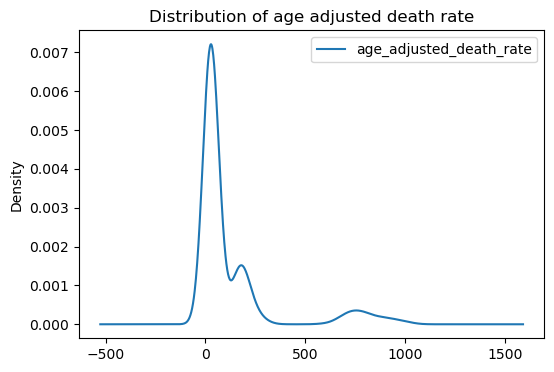

In [57]:
# Distribution of age_adjusted_death_rate
df_explore[['age_adjusted_death_rate']].plot(kind='kde', figsize=(6, 4), title='Distribution of age adjusted death rate')

The distribution is  right skewed but also bimodal.

We have already visualized and interpreted the distribution for the median household income for the impuation data correction section (See appendix). For reference we display the distribution again:

<AxesSubplot: title={'center': 'Distribution of median household income'}, ylabel='Density'>

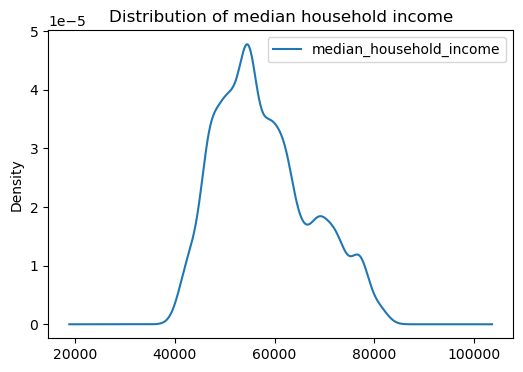

In [56]:
# Distribution of median_household_income
df_explore[['median_household_income']].plot(kind='kde', figsize=(6, 4), title='Distribution of median household income')

# Visualisierung wiederholen als bar plot mit Kategorien für Death causes, um Bimodale Verteilung zu erklären !

In [45]:
# Logarithmische skala für count, kategorien, title, x-achse. legende

alt.Chart(df_explore[['age_adjusted_death_rate']]).mark_bar().encode(
    alt.X("age_adjusted_death_rate:Q", bin=True),
    y='count()',
)

alt.Chart(...)

In [100]:
# Compare columns cause_name and 113_cause_name
cause_name = alt.Chart(df_explore).mark_bar().encode(
    alt.Y('cause_name:N',sort=alt.EncodingSortField(field="cause_name", op="count", order='ascending') ),
    alt.X('count(cause_name):Q', )
)

cause_name_113 = alt.Chart(df_explore).mark_bar().encode(
    alt.Y('113_cause_name:N',sort=alt.EncodingSortField(field="113_cause_name", op="count", order='ascending') ),
    alt.X('count(113_cause_name):Q')
)

# Vertical concatenation 
alt.vconcat(cause_name, cause_name_113)


alt.VConcatChart(...)

We can see that both categories display the same amounts of counts for each category. Like we predicted we only need to keep one column for the model since the information is duplicate.

In [103]:
df_explore.drop(['113_cause_name'], axis = 1, inplace = True)

Map!!!! 2 Stück 
Deathrate + Median income

https://altair-viz.github.io/gallery/choropleth.html

Irgendwas stimmt mit der Karte nicht!!!!! 

In [77]:
states = alt.topo_feature(data.us_10m.url, 'states')
source = df_explore
variable_list = ['age_adjusted_death_rate', 'median_household_income']

alt.Chart(states).mark_geoshape().encode(
    alt.Color(alt.repeat('row'), type='quantitative')
).transform_lookup(
    lookup='state',
    from_=alt.LookupData(source, 'state', variable_list)
).properties(
    width=500,
    height=300
).project(
    type='albersUsa'
).repeat(
    row=variable_list
).resolve_scale(
    color='independent'
)


alt.RepeatChart(...)

In [109]:
alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal='All causes')

).interactive()

alt.Chart(...)

In this chart, there is a clear negative correlation between the median household income and the age adjusted death rate. The more the median income is, the less the deaths are appearing.

In [112]:
Chart_CLRD=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal='CLRD',)

).interactive()

Chart_Alzheimer=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Alzheimer's disease")

).interactive()

Chart_Influenza=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Influenza and pneumonia")

).interactive()

Chart_Suicide=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Suicide")

).interactive()

Chart_Kidney=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Kidney disease")

).interactive()

Chart_Unintentional=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Unintentional injuries")

).interactive()

Chart_Diabetes=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Diabetes")

).interactive()

Chart_Stroke=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Stroke")

).interactive()

Chart_Cancer=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Cancer")
    
    ).interactive()
    
Chart_Heart=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Heart disease")

).interactive()

Horizontal1=Chart_CLRD | Chart_Alzheimer | Chart_Diabetes 
Horizontal2=Chart_Kidney | Chart_Suicide | Chart_Influenza 
Horizontal3=Chart_Stroke | Chart_Cancer | Chart_Heart | Chart_Unintentional
alt.vconcat(Horizontal1, Horizontal2, Horizontal3)

alt.VConcatChart(...)

These charts are showing all death causes in detail. We have one chart for each death cause. Also here there is the same negative correlation. It seems like, that the death cause is indifferent regarding this correlation. Cancer seems like the death cause with the strongest negative correlation.

### Relationships

In [147]:
# inspect correlation between outcome and possible predictors
corr = df_explore.corr()
corr[y_label].sort_values(ascending=False)

age_adjusted_death_rate    1.000000
cause_name                 0.402470
deaths                     0.224213
state                      0.005450
year                      -0.027888
median_household_income   -0.031676
Name: age_adjusted_death_rate, dtype: float64

The overview shows, that there is a negative correlation for year and median_household_income. That means, that our hyphothesis is supported by the data. The data shows in addition, that the more years pass, the less people die (looking at data from 1999-2017).

In [148]:
# take a look at all correlations
corr.style.background_gradient(cmap='Blues')

## TODO 
* Korrelation erläutern
* Begründung für Median Household Income geben, auch bei geringer negativer Korrelation

## Model

## Nico
### Kopieren aus Notebook 44 und Modeltypen passend zu proposal umsetzen

Abstimmung, welche Metriken und Erkenntnisse aus den Modellen für uns relevant sind

### Model type
Since the predictor and the response variable are numeric, and we try to find a patter between them, we have a regression problem.
We will start with simple linear regression since we suspect to only have one predictor (household income) and one response/dependent (death rate) variable and will assume a linear relationship. 

This assumption could change, depending on the insights we get from our analysis of the data. Therefore we will also take the following models into account:
* Polynomial Regression, in case the relationship between predictor and response variable is not linear
* Bayesian Regression
* Decision Tree Regression, mainly xgboost
* Gradient Descent Regression

In order to find the best performing model, we will compare them using a specific metric (e.g. Mean Squared Error or Mean Absolute Error)

Before we start we encode the categorical features as one hot numeric features (dummy variables) for the models and perform the data splitting again since we made changes:

In [155]:
#identify all categorical variables
list_cat = df_joined.select_dtypes(['category']).columns
#convert all categorical variables to numeric
df_joined[list_cat] = df_joined[list_cat].apply(lambda x: pd.factorize(x)[0])

df_joined

year  113_cause_name  cause_name  state  deaths  \
0      2017               0           0      0  169936   
1      2017               0           0      1    2703   
2      2017               0           0      2     436   
3      2017               0           0      3    4184   
4      2017               0           0      4    1625   
...     ...             ...         ...    ...     ...   
10863  1999              10          10     47    1035   
10864  1999              10          10     48     278   
10865  1999              10          10     49     345   
10866  1999              10          10     50     677   
10867  1999              10          10     51      30   

       age_adjusted_death_rate  median_household_income  
0                         49.4                  60300.0  
1                         53.8                  48100.0  
2                         63.7                  73200.0  
3                         56.2                  56600.0  
4                         51.8                  45900.0  
...                        ...                      ...  
10863                     16.9                  81400.0  
10864                      5.2                  67600.0  
10865                     16.4                  46200.0  
10866                     11.9                  57800.0  
10867                      6.8                  81400.0  

[10868 rows x 7 columns]

In [130]:
#identify all categorical variables
list_cat = df_joined.select_dtypes(['category']).columns
#convert all categorical variables to numeric
df_joined[list_cat] = df_joined[list_cat].apply(lambda x: pd.factorize(x)[0])

# Perform data splitting
y_label = 'age_adjusted_death_rate'
features = df_joined.drop(columns=[y_label]).columns.tolist()
X = df_joined[features]
y = df_joined[y_label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# data training set
df_train = pd.DataFrame(X_train.copy())
df_train = df_train.join(pd.DataFrame(y_train))

### Select model

In [131]:
# select the linear regression model
reg = LinearRegression()

### Training and validation

In [135]:
# cross-validation with 5 folds
scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error') *-1
scores

array([41408.69410858, 44798.43396066, 43583.81399548, 41611.77672192,
       39585.4400324 ])

In [136]:
# store cross-validation scores
df_scores = pd.DataFrame({"lr": scores})

# reset index to match the number of folds
df_scores.index += 1

# print dataframe
df_scores.style.background_gradient(cmap='Blues')

In [137]:
alt.Chart(df_scores.reset_index()).mark_line(
     point=alt.OverlayMarkDef()
).encode(
    x=alt.X("index", bin=False, title="Fold", axis=alt.Axis(tickCount=5)),
    y=alt.Y("lr", aggregate="mean", title="Mean squared error (MSE)")
)

alt.Chart(...)

In [138]:
df_scores.describe().T

count          mean          std           min           25%  \
lr    5.0  42197.631764  2029.462222  39585.440032  41408.694109   

             50%           75%           max  
lr  41611.776722  43583.813995  44798.433961

### Fit model

In [139]:
# Fit the model to the complete training data
reg.fit(X_train, y_train)

LinearRegression()

Coefficients

In [140]:
# intercept
intercept = pd.DataFrame({
    "Name": ["Intercept"],
    "Coefficient":[reg.intercept_]}
    )

# make a slope table
slope = pd.DataFrame({
    "Name": features,
    "Coefficient": reg.coef_}
)

# combine estimates of intercept and slopes
table = pd.concat([intercept, slope], ignore_index=True, sort=False)

round(table, 3)

Name  Coefficient
0                Intercept     2803.996
1                     year       -1.272
2           113_cause_name      -10.929
3               cause_name      -10.929
4                    state        0.332
5                   deaths        0.000
6  median_household_income       -0.000

### Evaluation on test set

In [142]:
# obtain predictions
y_pred = reg.predict(X_test)

In [143]:
# R squared
r2_score(y_test, y_pred).round(3)

0.164

In [144]:
# MSE
mean_squared_error(y_test, y_pred).round(3)

43356.188

In [145]:
# RMSE
mean_squared_error(y_test, y_pred, squared=False).round(3)

208.221

In [146]:
# MAE
mean_absolute_error(y_test, y_pred).round(3)

145.999

### Save model



Save your model in the folder `models/`. Use a meaningful name and a timestamp.

Wiederholudng für Lasso Regression

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train[list_numerical]) 

X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

## Conclusions

Am Ende die weiteren Schritte und bisherigen Interprationen auflisten.